In [14]:
import matplotlib.pyplot as plt # plotting
import numpy as np              # working with number arrays etc.
from netCDF4 import Dataset     # reading netcdf files
from numpy import trapz         # for integration

# all file paths: change according to file location
path_les="/Users/amrapallig/run/cvmix_analysis/les/"
path_adc="/Users/amrapallig/Desktop/cvmix/adc/convection/"
path_kpp="/Users/amrapallig/run/cvmix_analysis/les/KPP-CVMix/"
path_ke="/Users/amrapallig/run/cvmix_analysis/les/K-EPSILON-SG/"

In [15]:

# density calculation from given temp and salinity
def density_eos(t,s):
    density= 1026.0*(1.0-2e-4*(t-20)+8e-4*(s-35))
    return density

#rate of change of depth integrated potential energy calculation
def pot_energy2(temperature_0,temperature_t,salinity_0,salinity_t,depth,dtdz,dsdz,t=95):
    ind=np.where((depth)>-80)  ##plots are weird with, 5 m doing worse than 10m if whole depth 100m is selected
                                ## thats why I am taking depth till -75
    depth=depth[ind]
    #for initial time
    
    # defined initial profiles as data saved for les and adc are from 1 hr and 
    # for kpp and kepsilon are from zero hr
    #temp=20+dtdz*depth
    #salt=35+dsdz*depth 
    temp=temperature_0[ind]
    salt=salinity_0[ind]
    density= density_eos(temp,salt)
    # depth integrated potential energy PE=density*9.81*depth
    area=trapz(density*9.81*depth,depth)
    PE_0=area
    #print(PE_0)
    
    #for final time
    temp=temperature_t[ind]
    salt=salinity_t[ind]
    density= density_eos(temp,salt)
    plt.plot(density,depth)
    plt.ylim(-20,0)
    # depth integrated potential energy PE=density*9.81*depth
    # area under PE
    area=trapz(density*9.81*depth,depth)
    PE_t=area
    PE_rate_change=(PE_t-PE_0)/(3600*t)  # in Watt/m^2
    #print(PE_t)
    return (PE_rate_change)


{'pe_c2_les': 0.00019524290976904288}

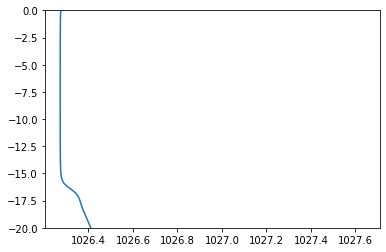

In [16]:
# time step
t = 96  # as KPP and KE have 95 hrs of data stratibg from zero
# range of time for averaging
t1 = t-4

# LES
#path_les="/Users/amrapalli/runs/cvmix/cvmix_analysis/les/"
results_les = {}
#vertical resolutions
#datasets = [1, 2, 5, 10] 
# list comprehension
file_names = [*[f"Cooling{x}" for x in [1, 2, 4, 16]], 
              *[f"Evap{x}" for x in [1, 4]],
              *[f"Strat{x}" for x in [1, 10, 20]],
              *[f"T1S{x}" for x in [0, 1, 3, 15]],
             ]

# #file_names
# for fn in file_names:
#     les= Dataset(path_les+f'{fn}.nc', mode='r')

# #         # compute pot
    
#     if "Cooling" in fn:
#         fn = fn.replace("Cooling", "c")
#         dtdz=0.1; dsdz=0.0
#     if "Evap" in fn:
#         fn = fn.replace("Evap", "e")
#         dtdz=0.0; dsdz=-0.025
#     if "Strat" in fn:
#         fn = fn.replace("Strat", "s")
#         if "10" in fn:
#             dtdz=0.1; dsdz=0.0
#         elif "1" in fn:
#             dtdz=0.01; dsdz=0.0
#         elif "20" in fn:
#             dtdz=0.2; dsdz=0.0
#         else: 
#             print("error")
#     if "T1S" in fn:
#         fn = fn.replace("T1S", "t1s")
#         dtdz=0.05; dsdz=-0.025
#     #print(fn,dtdz,dsdz)
les= Dataset(path_les+'Cooling2.nc', mode='r')

results_les["pe_c2_les"] = pot_energy2(les.variables["temp"][0,:],
                                              np.nanmean(les.variables["temp"][t1:t,:],axis=0),
                                              les.variables["salt"][0,:],
                                              np.nanmean(les.variables["salt"][t1:t,:],axis=0),
                                              les.variables['zm'][:],
                                              dtdz=0.1,
                                              dsdz=0.0)
results_les

{'pe_c2_adcdtp5s': 0.00019548585019700708,
 'pe_c2_adcdt1s': 0.0001932532756061059,
 'pe_c2_adcdt2s': 0.00019342204985039972,
 'pe_c2_adcdt5s': 0.00019674077347923093}

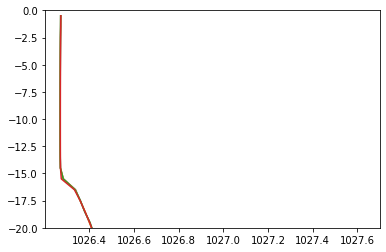

In [8]:
# ADC
# time step
t = 96  # as KPP and KE have 95 hrs of data stratibg from zero
# range of time for averaging
t1 = t-4
path_adc="/Users/amrapallig/run/cvmix_test/forward/output/convection/time_sensitivity/"
results_adc_c2_adcdt = {}

#resolutions = [1, 2, 5, 10]
#resolutions = [10]
#file_names = ["c1", "c2", "c4", "c16", 
#              "e1", "e4", 
#              "s1", "s10", "s20", 
#              "t1s0", "t1s1", "t1s3", "t1s15"]
file_names_adcdt = ["p5s","1s","2s","5s"]
#file_names_dt = ["5min","10min","30min","1hr","2hr"]
for fn in file_names_adcdt:  
        mf = Dataset(path_adc+f'adcTurbulenceArrays_c2_1m_adcdt{fn}_dt1hr.nc', mode='r')  
        fh = Dataset(path_adc+f'output.0001-01-01_00.00_c2_1m_adcdt{fn}_dt1hr.nc', mode='r')
        dtdz=0.1; dsdz=0.0 #for c2
       
                         
        # compute pot
        results_adc_c2_adcdt[f"pe_c2_adcdt{fn}"] = pot_energy2(mf.variables["temperature"][0,0,:],
                                                   np.nanmean(mf.variables["temperature"][t1:t,0,:],axis=0),
                                                   mf.variables["salinity"][0,0,:],
                                                  np.nanmean(mf.variables["salinity"][t1:t,0,:],axis=0),
                                                  fh.variables['zMid'][0,0,:],
                                                  dtdz,
                                                  dsdz)
results_adc_c2_adcdt


In [9]:
relative_errors_adcdt = {}

file_names_adcdt = ["p5s","1s","2s","5s"]
for fn in file_names_adcdt:
    numerator = results_les["pe_c2_les"] - results_adc_c2_adcdt[f"pe_c2_adcdt{fn}"]
    relative_errors_adcdt[f"c2_adcdt{fn}"] = numerator/results_les["pe_c2_les"]
        
relative_errors_adcdt


{'c2_adcdtp5s': -0.0012442983371410304,
 'c2_adcdt1s': 0.010190557830195077,
 'c2_adcdt2s': 0.009326125700529136,
 'c2_adcdt5s': -0.007671795672170145}

{'pe_c2_dt5min': 0.00019192431690661532,
 'pe_c2_dt10min': 0.00019204526955577715,
 'pe_c2_dt30min': 0.00019253194009700015,
 'pe_c2_dt1hr': 0.0001932532756061059,
 'pe_c2_dt2hr': 0.00019447149444175394}

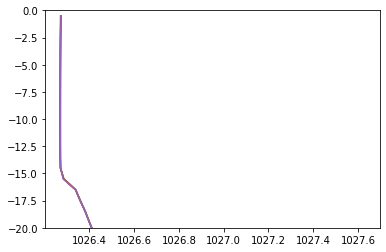

In [10]:
# ADC
path_adc="/Users/amrapallig/run/cvmix_test/forward/output/convection/time_sensitivity/"
results_adc_c2_dt = {}

#resolutions = [1, 2, 5, 10]
#resolutions = [10]
#file_names = ["c1", "c2", "c4", "c16", 
#              "e1", "e4", 
#              "s1", "s10", "s20", 
#              "t1s0", "t1s1", "t1s3", "t1s15"]
#file_names_adcdt = ["p5s","1s","2s","5s"]
file_names_dt = ["5min","10min","30min","1hr","2hr"]
for fn in file_names_dt:  
        mf = Dataset(path_adc+f'adcTurbulenceArrays_c2_1m_adcdt1s_dt{fn}.nc', mode='r')  
        fh = Dataset(path_adc+f'output.0001-01-01_00.00_c2_1m_adcdt1s_dt{fn}.nc', mode='r')
        dtdz=0.1; dsdz=0.0 #for c2
        
        if fn=="1hr":
            t=96; t1=t-4                 #1hr
        if fn=="2hr":
            t=int(96/2); t1=t-int(4/2)   #2hr
        if fn=="30min":
            t=int(96*2); t1=t-int(4*2)   #30min
        if fn=="10min":
            t=int(96*6); t1=t-int(4*6)   #10min
        if fn=="5min":
            t=int(96*12); t1=t-int(4*12)  #5minmin
        
        # compute pot
        results_adc_c2_dt[f"pe_c2_dt{fn}"] = pot_energy2(mf.variables["temperature"][0,0,:],
                                                   np.nanmean(mf.variables["temperature"][t1:t,0,:],axis=0),
                                                   mf.variables["salinity"][0,0,:],
                                                  np.nanmean(mf.variables["salinity"][t1:t,0,:],axis=0),
                                                  fh.variables['zMid'][0,0,:],
                                                  dtdz,
                                                  dsdz)
results_adc_c2_dt

In [11]:
relative_errors_dt = {}

file_names_dt = ["5min","10min","30min","1hr","2hr"]
for fn in file_names_dt:
    numerator = results_les["pe_c2_les"] - results_adc_c2_dt[f"pe_c2_dt{fn}"]
    relative_errors_dt[f"c2_dt{fn}"] = numerator/results_les["pe_c2_les"]
    
    
        
relative_errors_dt


{'c2_dt5min': 0.01699725161007486,
 'c2_dt10min': 0.01637775331789662,
 'c2_dt30min': 0.013885112013796518,
 'c2_dt1hr': 0.010190557830195077,
 'c2_dt2hr': 0.00395105424417955}

In [ ]:
relative_errors_dt

(array([-0.1  , -0.075, -0.05 , -0.025,  0.   ,  0.025,  0.05 ,  0.075,
         0.1  ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

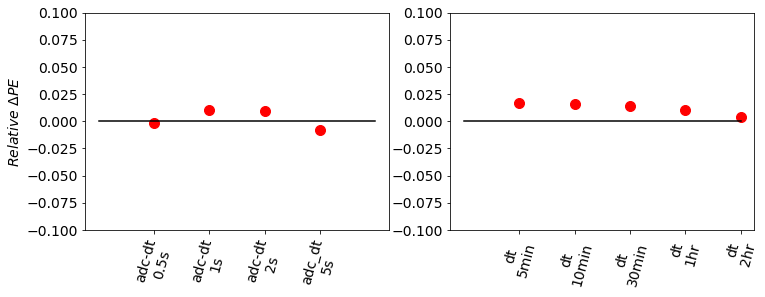

In [13]:
plt.figure(figsize=(12,4))
plt.subplot(121)

a=2,4,6,8
plt.plot(a[0],relative_errors_adcdt["c2_adcdtp5s"],'or',markersize=10)
plt.plot(a[1],relative_errors_adcdt["c2_adcdt1s"],'or',markersize=10)
plt.plot(a[2],relative_errors_adcdt["c2_adcdt2s"],'or',markersize=10)
plt.plot(a[3],relative_errors_adcdt["c2_adcdt5s"],'or',markersize=10)

#plt.plot(a[0],c4_adcp5s,'ok',markersize=10)
#plt.plot(a[1],c4_adc1s,'ok',markersize=10)
#plt.plot(a[2],c4_adc2s,'ok',markersize=10)
#plt.plot(a[3],c4_adc5s,'ok',markersize=10)


plt.ylim(-0.1,0.1)

plt.plot([0,10],[0,0],'-k')
plt.xticks([2,4,6,8], ['adc-dt\n0.5s', 'adc-dt\n1s', 'adc-dt\n2s','adc_dt\n5s'],rotation=75,fontsize=14)
plt.ylabel("$Relative$ $\Delta PE$",fontsize=14)
#plt.xlabel("$Test$ $cases$",fontsize=14)#plt.legend(["1m","2m","5m","10m"])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(122)

a=2,4,6,8,10
plt.plot(a[1],relative_errors_dt["c2_dt10min"],'or',markersize=10)
plt.plot(a[2],relative_errors_dt["c2_dt30min"],'or',markersize=10)
plt.plot(a[3],relative_errors_dt["c2_dt1hr"],'or',markersize=10)
plt.plot(a[4],relative_errors_dt["c2_dt2hr"],'or',markersize=10)
plt.plot(a[0],relative_errors_dt["c2_dt5min"],'or',markersize=10)


plt.ylim(-0.1,0.1)

plt.plot([0,10],[0,0],'-k')
plt.xticks([2,4,6,8,10], ['dt\n5min','dt\n10min', 'dt\n30min', 'dt\n1hr','dt\n2hr'],rotation=75,fontsize=14)
#plt.ylabel("$Relative$ $\Delta PE$",fontsize=14)
#
#plt.xlabel("$Test$ $cases$",fontsize=14)#plt.legend(["1m","2m","5m","10m"])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)